In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import json
import requests
from pprint import pprint
from collections import Counter

In [2]:
data_dir = "/Users/ak/tte/data/sample-data/gsm"

basline_dir = data_dir + "/baseline_pass_20_ckpt_200" 
s3c_dir = data_dir + "/s3c_trace_pass_20_ckpt_1000" 


basline_json_file_path = basline_dir + "/predict_predictions.json"
basline_stat_log_path = basline_dir + "/predict_results.json"

s3c_json_file_path = s3c_dir + "/predict_predictions.json"
s3c_stat_log_path = s3c_dir + "/predict_results.json"

In [3]:
basline_stat_log_data = pd.read_json(basline_stat_log_path, typ='series')
basline_stat_log_dict = basline_stat_log_data.to_dict()

s3c_stat_log_data = pd.read_json(s3c_stat_log_path, typ='series')
s3c_stat_log_dict = s3c_stat_log_data.to_dict()

### Basline gsm pass@20 vs s3c round 0 pass@20

In [4]:
print(f" Basline: {basline_stat_log_dict['test_raw_pass@20']}% | s3c: {s3c_stat_log_dict['test_round_0_estimated_pass@20']}%")

 Basline: 43.5178% | s3c: 36.8461%


In [5]:
basline_json = pd.read_json(basline_json_file_path)
baseline_dict = basline_json.to_dict()

In [6]:
s3c_json = pd.read_json(s3c_json_file_path)
s3c_dict = s3c_json.to_dict()

In [7]:
def get_clusters(generated_programs_dict):

    clusters_dict = {}
    clusters_list = []
    
    for prompt in generated_programs_dict:
        i = 0

        programs_list = []
        while i < len(generated_programs_dict[prompt]):
            programs_list.append( generated_programs_dict[prompt][i]['generated_program'])
            i+=1

        counts = Counter(programs_list)
        
        for cluster in counts:
            indices = [i for i in range(len(generated_programs_dict[prompt])) if programs_list[i] == cluster]
            clusters_list.append(indices)
        clusters_dict.update({prompt:clusters_list})
        clusters_list = []

    return clusters_dict

In [8]:
basline_clusters_dict = get_clusters(baseline_dict)
s3c_clusters_dict = get_clusters(s3c_dict)

In [9]:
def filter_failed_prompts(baseline_dict):
    count = 0 
    
    failed_list = []
        
    for prompt in baseline_dict:
        fail_state = True
        for output in baseline_dict[prompt]:
            if(baseline_dict[prompt][output]['compiler_output'][0] == True):
                fail_state = False
                break
        if fail_state:
            failed_list.append(prompt)
        

    return(failed_list)

In [10]:
def filter_passing_prompts(s3c_dict):
    count = 0 
    
    passed_list = []
        
    for prompt in s3c_dict:
        success_state = False
        for output in s3c_dict[prompt]:
            if(s3c_dict[prompt][output]['compiler_output'][0] == True):
                success_state = True
                break
        if success_state:
            passed_list.append(prompt)
        

    return(passed_list)

In [11]:
def filter_clusters(generated_programs_dict, clusters_dict, correct_only = None, cluster_size_range = (1,5)):
    count = 0 
    
    filtered_dict = {}
    
    for cluster_id in clusters_dict:
        # if count == 23: break #Debug early stopping
        # count+=1

        filtered_clusters_list = []
        
        for cluster in clusters_dict[cluster_id]:
            if (cluster_size_range[0] <= (len(clusters_dict[cluster_id])) <= cluster_size_range[1]):
                if correct_only == True:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == True):
                        filtered_clusters_list.append(cluster)
                elif correct_only == False:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == False):
                        #print(cluster_id, cluster[0])
                        filtered_clusters_list.append(cluster)
                else:
                    filtered_clusters_list.append(cluster)
                    
        if(len(filtered_clusters_list) > 0): filtered_dict.update({cluster_id:filtered_clusters_list})

    return(filtered_dict)

In [12]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))

In [13]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [14]:
#pprint(filter_failed_prompts(baseline_dict))
#pprint(filter_passing_prompts(s3c_dict))

tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

print( len(tf_intersection) )
print( tf_intersection )

156
['test_1228', 'test_1141', 'test_674', 'test_523', 'test_304', 'test_731', 'test_380', 'test_48', 'test_1272', 'test_835', 'test_299', 'test_25', 'test_27', 'test_497', 'test_31', 'test_596', 'test_557', 'test_923', 'test_1301', 'test_994', 'test_1133', 'test_1014', 'test_1114', 'test_848', 'test_1082', 'test_906', 'test_840', 'test_877', 'test_745', 'test_1041', 'test_146', 'test_88', 'test_948', 'test_467', 'test_344', 'test_891', 'test_987', 'test_311', 'test_121', 'test_913', 'test_1050', 'test_1000', 'test_726', 'test_1276', 'test_1121', 'test_929', 'test_922', 'test_597', 'test_760', 'test_35', 'test_893', 'test_442', 'test_667', 'test_706', 'test_94', 'test_1013', 'test_774', 'test_768', 'test_39', 'test_147', 'test_905', 'test_649', 'test_743', 'test_673', 'test_615', 'test_1036', 'test_902', 'test_790', 'test_1119', 'test_744', 'test_129', 'test_798', 'test_661', 'test_668', 'test_1047', 'test_964', 'test_177', 'test_1066', 'test_378', 'test_231', 'test_644', 'test_682', '

In [15]:
reversed_tf_intersection = intersection(filter_failed_prompts(s3c_dict), filter_passing_prompts(baseline_dict))
print(len(reversed_tf_intersection))
print(reversed_tf_intersection)

186
['test_1019', 'test_796', 'test_809', 'test_412', 'test_1182', 'test_495', 'test_1283', 'test_1273', 'test_470', 'test_1261', 'test_742', 'test_1264', 'test_1217', 'test_653', 'test_1208', 'test_1177', 'test_530', 'test_652', 'test_647', 'test_522', 'test_477', 'test_927', 'test_447', 'test_51', 'test_1005', 'test_441', 'test_800', 'test_841', 'test_1099', 'test_1058', 'test_1125', 'test_1275', 'test_136', 'test_511', 'test_863', 'test_386', 'test_838', 'test_89', 'test_951', 'test_1064', 'test_1198', 'test_556', 'test_665', 'test_499', 'test_885', 'test_291', 'test_715', 'test_1152', 'test_904', 'test_807', 'test_910', 'test_135', 'test_735', 'test_1170', 'test_1200', 'test_1167', 'test_803', 'test_1078', 'test_396', 'test_206', 'test_578', 'test_107', 'test_1248', 'test_187', 'test_259', 'test_173', 'test_959', 'test_397', 'test_697', 'test_892', 'test_1024', 'test_446', 'test_16', 'test_431', 'test_912', 'test_1279', 'test_759', 'test_1285', 'test_145', 'test_1227', 'test_308', 

In [16]:
len(filter_failed_prompts(baseline_dict)), len(filter_failed_prompts(s3c_dict))

(745, 775)

In [17]:
len( intersection(filter_failed_prompts(s3c_dict), filter_failed_prompts(baseline_dict)) )

589

In [18]:
len(filter_passing_prompts(baseline_dict)), len(filter_passing_prompts(s3c_dict))

(574, 544)

In [19]:
print(30/1300)

0.023076923076923078


In [20]:
len(baseline_dict), len(s3c_dict)

(1319, 1319)

In [21]:
basline_clusters_dict['test_743']

[[0, 7, 13, 17, 18],
 [1, 2, 4, 5, 6, 8, 11, 14, 15],
 [3],
 [9, 10],
 [12],
 [16],
 [19]]

In [22]:
tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

In [23]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))
correct_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, True, (1, 20))

In [30]:
pprint(baseline_dict['test_1272'][0]['prompt'])

('QUESTION:\n'
 'Helen went on a trip through Germany. She booked a hotel for 3 nights and '
 'rode the bus 7 times during that trip. One night at the hotel was a cost of '
 '$80, and every bus trip was 10% of the price of one night at the hotel. How '
 'much did Helen pay for the hotel and bus travels during that trip?\n'
 'ANSWER:\n')


In [52]:
def get_longest(lst):
    return max(lst, key=len)

def find_overlap( tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters, false_to_true = True): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])
        
        if false_to_true:
            basline_msg = "Incorrect Baseline Generation: \n"
            s3c_msg = "Correct S3C Generation: \n"
            
        else:
            basline_msg = "Correct Baseline Generation: \n"
            s3c_msg = "Incorrect S3C Generation: \n"            
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                print( f"Prompt: {prompt} \n")
                print(f"Count: {count}")
                count+=1
                print(basline_msg)
                print( baseline_dict[prompt][basline_cluster[0]]['generated_program'] )

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_b}") 

                print("----------------------------------------------------------------")

                print(s3c_msg)
                print( s3c_dict[prompt][s3c_cluster[0]]['generated_program'] )

                #gt_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['expected_answer']
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_s3}") 
                print("----------------------------------------------------------------")
                
                print("Ground Truth Program: \n")
                print( baseline_dict[prompt][0]['ground_truth_program'] )
                print(f"Ground Truth Answer: {gt_ans}") 
                
                print("----------------------------------------------------------------")
                print("Notes: ")
                print("|=================================================================================================================================|\n")
        

In [ ]:
#find_overlap(tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters) #Print cases where basline solved the prompt incorrect and s3c solved it correctly

In [37]:
correct_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, True, (1, 20))
incorrect_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, False, (1, 20))

In [44]:
ft_intersection = intersection(filter_passing_prompts(baseline_dict), filter_failed_prompts(s3c_dict))

In [45]:
print(ft_intersection)

['test_1019', 'test_796', 'test_809', 'test_412', 'test_1182', 'test_495', 'test_1283', 'test_1273', 'test_470', 'test_1261', 'test_742', 'test_1264', 'test_1217', 'test_653', 'test_1208', 'test_1177', 'test_530', 'test_652', 'test_647', 'test_522', 'test_477', 'test_927', 'test_447', 'test_51', 'test_1005', 'test_441', 'test_800', 'test_841', 'test_1099', 'test_1058', 'test_1125', 'test_1275', 'test_136', 'test_511', 'test_863', 'test_386', 'test_838', 'test_89', 'test_951', 'test_1064', 'test_1198', 'test_556', 'test_665', 'test_499', 'test_885', 'test_291', 'test_715', 'test_1152', 'test_904', 'test_807', 'test_910', 'test_135', 'test_735', 'test_1170', 'test_1200', 'test_1167', 'test_803', 'test_1078', 'test_396', 'test_206', 'test_578', 'test_107', 'test_1248', 'test_187', 'test_259', 'test_173', 'test_959', 'test_397', 'test_697', 'test_892', 'test_1024', 'test_446', 'test_16', 'test_431', 'test_912', 'test_1279', 'test_759', 'test_1285', 'test_145', 'test_1227', 'test_308', 'tes

In [ ]:
#find_overlap(ft_intersection, baseline_dict, s3c_dict, correct_baseline_clusters, incorrect_s3c_clusters, False)

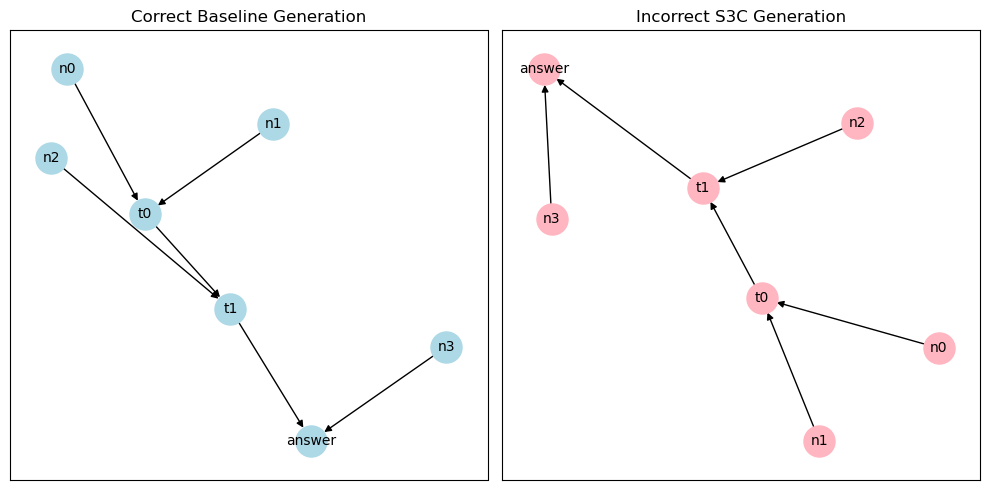

In [54]:
import networkx as nx

# Create an empty directed graph
graph_correct = nx.DiGraph()
graph_incorrect = nx.DiGraph()

# Correct Baseline Generation
graph_correct.add_node("n0")
graph_correct.add_node("n1")
graph_correct.add_node("n2")
graph_correct.add_node("n3")
graph_correct.add_node("t0")
graph_correct.add_node("t1")
graph_correct.add_node("answer")

graph_correct.add_edge("n0", "t0")
graph_correct.add_edge("n1", "t0")
graph_correct.add_edge("t0", "t1")
graph_correct.add_edge("n2", "t1")
graph_correct.add_edge("t1", "answer")
graph_correct.add_edge("n3", "answer")

# Incorrect S3C Generation
graph_incorrect.add_node("n0")
graph_incorrect.add_node("n1")
graph_incorrect.add_node("n2")
graph_incorrect.add_node("n3")
graph_incorrect.add_node("t0")
graph_incorrect.add_node("t1")
graph_incorrect.add_node("answer")

graph_incorrect.add_edge("n0", "t0")
graph_incorrect.add_edge("n1", "t0")
graph_incorrect.add_edge("t0", "t1")
graph_incorrect.add_edge("n2", "t1")
graph_incorrect.add_edge("t1", "answer")
graph_incorrect.add_edge("n3", "answer")

# Draw the graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(graph_correct, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(graph_incorrect, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()


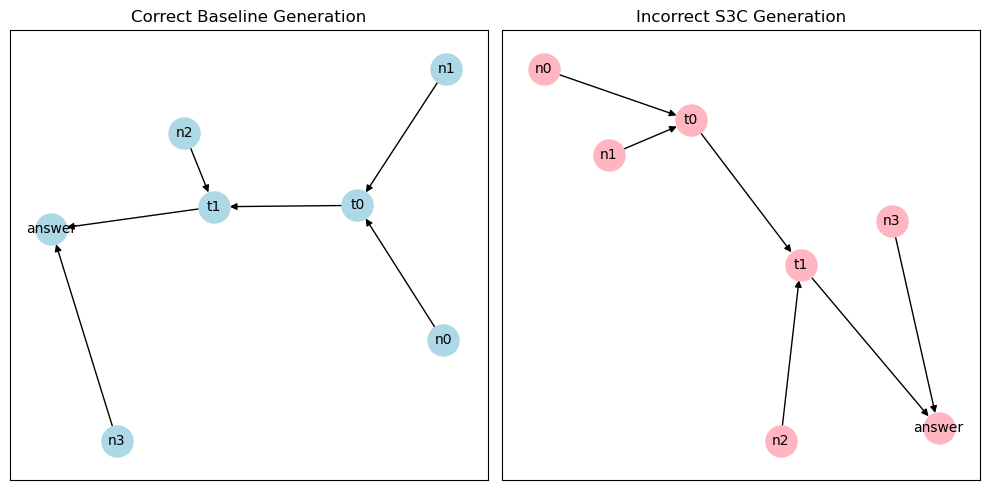

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()

    lines = string.strip().split("\n")
    for line in lines:
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            graph.add_node(var)

            # Find dependencies using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            for dep in dependencies:
                graph.add_edge(dep, var)

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# Create the graph for the input string
baseline_graph = parse_string_to_graph(correct_string)

s3c_graph = parse_string_to_graph(incorrect_string)


# Draw the graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(baseline_graph, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(s3c_graph, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()



In [82]:
import networkx as nx

# Create graphs (graph_correct and graph_incorrect) as shown previously

# Check for graph isomorphism
is_isomorphic = nx.is_isomorphic(graph_correct, graph_incorrect)
print("Graphs are isomorphic:", is_isomorphic)

# Check for subgraph isomorphism
subgraph_match = nx.algorithms.isomorphism.vf2userfunc.GraphMatcher(graph_correct, graph_incorrect)
subgraph_match_results = list(subgraph_match.subgraph_monomorphisms_iter())
print("Subgraph isomorphism matches:")
#pprint(subgraph_match_results)


Graphs are isomorphic: True
Subgraph isomorphism matches:


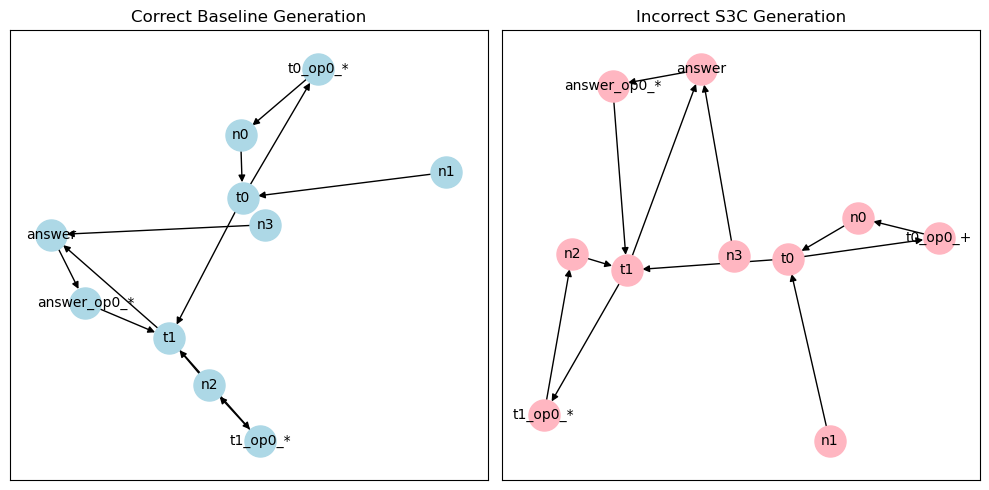

In [86]:
import networkx as nx
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables, operators, and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()

    lines = string.strip().split("\n")
    for line in lines:
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            graph.add_node(var)

            # Find dependencies and operators using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            operators = re.findall(r"([\*+/-])", expr)
            
            for i, dep in enumerate(dependencies):
                graph.add_edge(dep, var)
                if i < len(operators):
                    op_node = f"{var}_op{i}_{operators[i]}"
                    graph.add_node(op_node, label=operators[i])
                    graph.add_edge(var, op_node)
                    graph.add_edge(op_node, dep)

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# Create the graph for the input string
baseline_graph = parse_string_to_graph(correct_string)

s3c_graph = parse_string_to_graph(incorrect_string)


# Draw the graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(baseline_graph, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(s3c_graph, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()

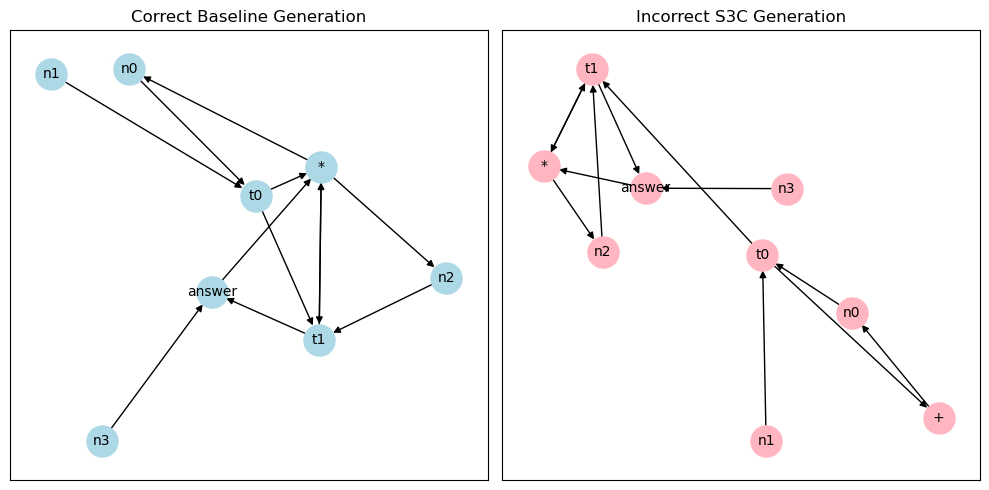

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables, operators, and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()

    lines = string.strip().split("\n")
    for line in lines:
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            graph.add_node(var)

            # Find dependencies and operators using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            operators = re.findall(r"([\*+/-])", expr)
            
            for i, dep in enumerate(dependencies):
                graph.add_edge(dep, var)
                if i < len(operators):
                    op_node = f"{operators[i]}"
                    graph.add_node(op_node, label=operators[i])
                    graph.add_edge(var, op_node)
                    graph.add_edge(op_node, dep)

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# Create the graph for the input string
baseline_graph = parse_string_to_graph(correct_string)

s3c_graph = parse_string_to_graph(incorrect_string)


# Draw the graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(baseline_graph, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(s3c_graph, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()

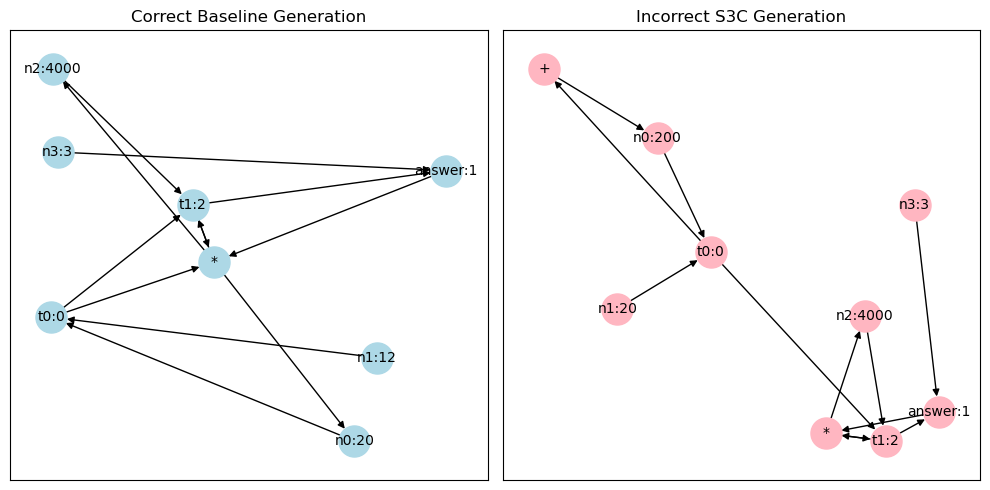

In [95]:
import networkx as nx
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables, values, operators, and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()

    lines = string.strip().split("\n")
    for line in lines:
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            # Get value of variable
            value = re.findall(r"([0-9]+)", expr)
            if value:
                graph.add_node(var, value=value[0])

            # Find dependencies and operators using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            operators = re.findall(r"([\*+/-])", expr)
            
            for i, dep in enumerate(dependencies):
                graph.add_edge(dep, var)
                if i < len(operators):
                    op_node = f"{operators[i]}"
                    graph.add_node(op_node, label=operators[i])
                    graph.add_edge(var, op_node)
                    graph.add_edge(op_node, dep)

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# Create the graph for the input string
baseline_graph = parse_string_to_graph(correct_string)
s3c_graph = parse_string_to_graph(incorrect_string)

# Create label mapping
baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}

# Draw the graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(baseline_graph, labels=baseline_labels, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(s3c_graph, labels=s3c_labels, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()

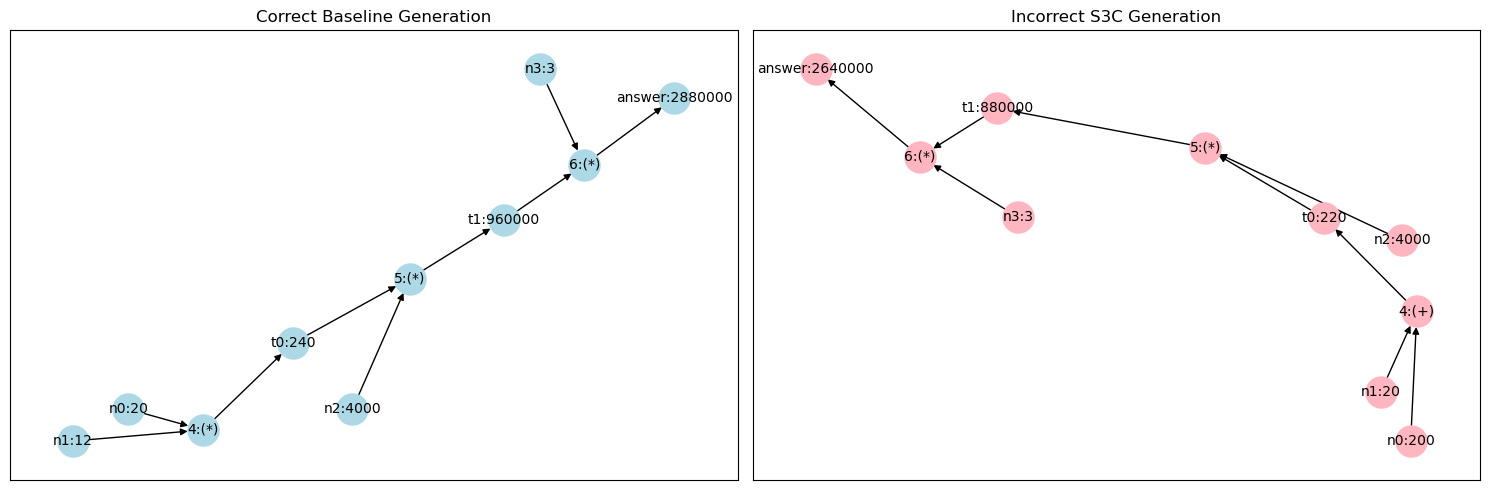

In [116]:
import networkx as nx
import matplotlib.pyplot as plt
import re

# Function to parse the string and extract variables, values, operators, and dependencies
def parse_string_to_graph(string):
    graph = nx.DiGraph()
    values = {}

    lines = string.strip().split("\n")
    for idx, line in enumerate(lines):
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            # Find dependencies and operators using regex
            dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
            operators = re.findall(r"([\*+/-])", expr)
            
            for i, op in enumerate(operators):
                op_node = f"{idx}:({op})"
                # add edges for operands and operations
                graph.add_edge(dependencies[i], op_node)
                graph.add_edge(dependencies[i+1], op_node)
                graph.add_edge(op_node, var)

                # calculate the value
                if op == '*':
                    values[var] = values[dependencies[i]] * values[dependencies[i+1]]
                elif op == '+':
                    values[var] = values[dependencies[i]] + values[dependencies[i+1]]
                elif op == '-':
                    values[var] = values[dependencies[i]] - values[dependencies[i+1]]
                elif op == '/':
                    values[var] = values[dependencies[i]] / values[dependencies[i+1]]

            # If no operator is found, then it's a direct assignment
            if not operators:
                values[var] = int(expr)
                graph.add_node(var, value=values[var])
            else:
                graph.add_node(var, value=values[var])

    return graph

# Define the input string
correct_string = """
n0=20
n1=12
n2=4000
n3=3
t0=n0*n1
t1=n2*t0
answer=t1*n3
"""

incorrect_string = """
n0=200
n1=20
n2=4000
n3=3
t0=n0+n1
t1=n2*t0
answer=t1*n3
"""

# Create the graph for the input string
baseline_graph = parse_string_to_graph(correct_string)
s3c_graph = parse_string_to_graph(incorrect_string)

# Create label mapping
baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}

# Draw the graphs
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Correct Baseline Generation")
nx.draw_networkx(baseline_graph, labels=baseline_labels, with_labels=True, node_color="lightblue", node_size=500, font_size=10)

plt.subplot(1, 2, 2)
plt.title("Incorrect S3C Generation")
nx.draw_networkx(s3c_graph, labels=s3c_labels, with_labels=True, node_color="lightpink", node_size=500, font_size=10)

plt.tight_layout()
plt.show()

In [117]:
import networkx.algorithms.isomorphism as iso

# Create a subgraph isomorphism matcher
matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

# Find all subgraph isomorphisms (common patterns)
subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

# Print common patterns
print("Common patterns found:")
for match in subgraph_matches:
    print(match)

Common patterns found:
{'n1': 'n0', '4:(*)': '4:(+)', 't0': 't0', '5:(*)': '5:(*)', 't1': 't1', '6:(*)': '6:(*)', 'answer': 'answer', 'n0': 'n1', 'n2': 'n2', 'n3': 'n3'}
{'n0': 'n0', '4:(*)': '4:(+)', 't0': 't0', '5:(*)': '5:(*)', 't1': 't1', '6:(*)': '6:(*)', 'answer': 'answer', 'n1': 'n1', 'n2': 'n2', 'n3': 'n3'}


Unique nodes in Baseline Graph: {'4:(*)'}
Unique nodes in S3C Graph: {'4:(+)'}
Unique edges in Baseline Graph: {('4:(*)', 't0'), ('n0', '4:(*)'), ('n1', '4:(*)')}
Unique edges in S3C Graph: {('n0', '4:(+)'), ('n1', '4:(+)'), ('4:(+)', 't0')}


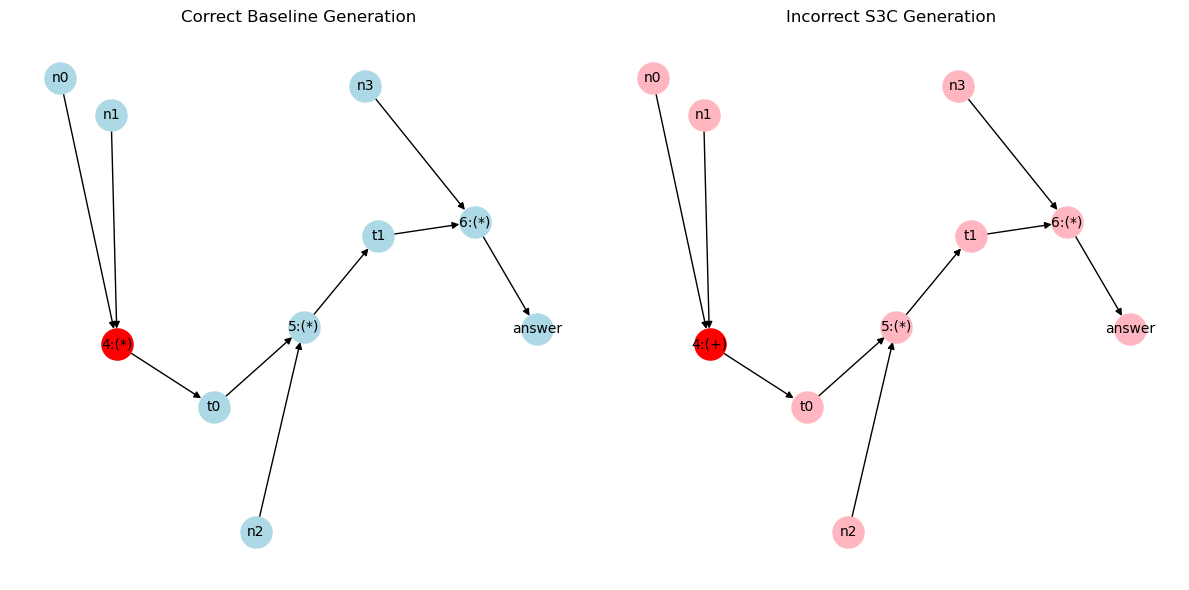

In [137]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re

# ... (previous code to parse the strings and create baseline_graph and s3c_graph)

# Create a subgraph isomorphism matcher
matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

# Find all subgraph isomorphisms (common patterns)
subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

# Find the nodes and edges that are unique to each graph
unique_nodes_baseline = set(baseline_graph.nodes()) - set(s3c_graph.nodes())
unique_nodes_s3c = set(s3c_graph.nodes()) - set(baseline_graph.nodes())

unique_edges_baseline = set(baseline_graph.edges()) - set(s3c_graph.edges())
unique_edges_s3c = set(s3c_graph.edges()) - set(baseline_graph.edges())

# Print the unique nodes and edges in each graph
print("Unique nodes in Baseline Graph:", unique_nodes_baseline)
print("Unique nodes in S3C Graph:", unique_nodes_s3c)

print("Unique edges in Baseline Graph:", unique_edges_baseline)
print("Unique edges in S3C Graph:", unique_edges_s3c)

# Create a new figure and axis for drawing the graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Draw the baseline graph
axes[0].set_title("Correct Baseline Generation")
pos_baseline = nx.spring_layout(baseline_graph, seed=42)
nx.draw(baseline_graph, pos=pos_baseline, with_labels=True, node_color="lightblue", node_size=500, font_size=10, ax=axes[0])
nx.draw_networkx_nodes(baseline_graph, pos=pos_baseline, nodelist=unique_nodes_baseline, node_color="red", node_size=500, ax=axes[0])

# Draw the s3c graph
axes[1].set_title("Incorrect S3C Generation")
pos_s3c = nx.spring_layout(s3c_graph, seed=42)
nx.draw(s3c_graph, pos=pos_s3c, with_labels=True, node_color="lightpink", node_size=500, font_size=10, ax=axes[1])
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=unique_nodes_s3c, node_color="red", node_size=500, ax=axes[1])

plt.tight_layout()
plt.show()

Unique nodes in Baseline Graph: {'4:(*)'}
Unique nodes in S3C Graph: {'4:(+)'}
Unique edges in Baseline Graph: {('4:(*)', 't0'), ('n0', '4:(*)'), ('n1', '4:(*)')}
Unique edges in S3C Graph: {('n0', '4:(+)'), ('n1', '4:(+)'), ('4:(+)', 't0')}


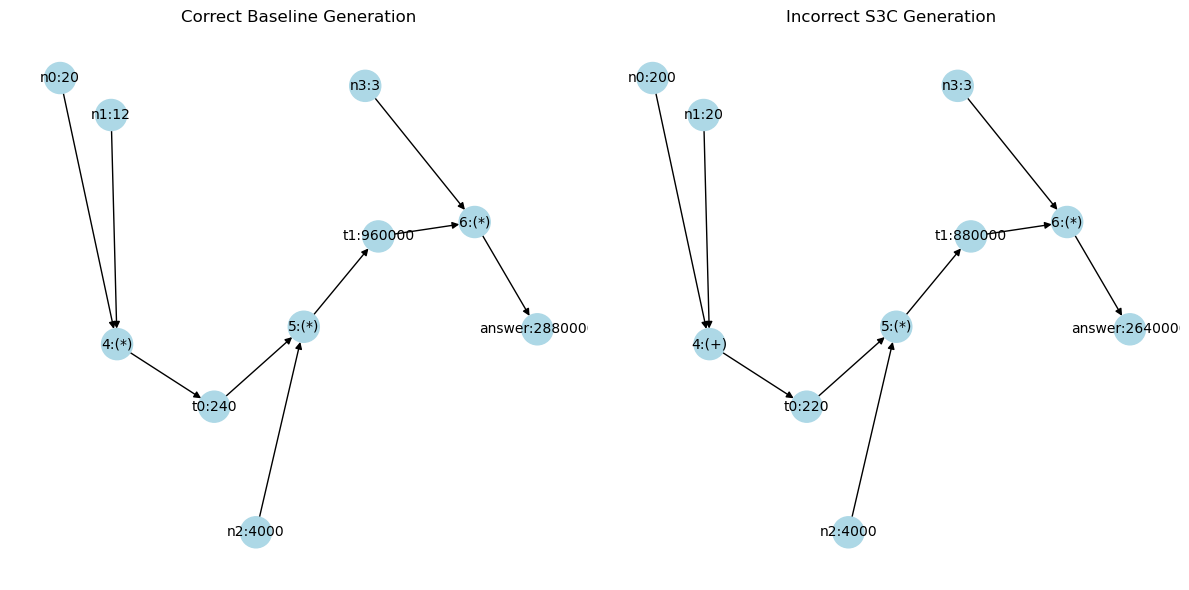

In [136]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re

# ... (previous code to parse the strings and create baseline_graph and s3c_graph)

# Function to set variable values and operators as attributes and labels in the graph nodes
def set_node_attributes(graph, var_values):
    for node, data in graph.nodes(data=True):
        if "value" in data:
            value = data["value"]
            data["label"] = f"{node}:{value}"
        elif "operator" in data:
            operator = data["operator"]
            data["label"] = operator
        else:
            data["label"] = node
        if node in var_values:
            if var_values[node] != data.get("value"):
                data["color"] = "red"
            else:
                data["color"] = "lightblue"
        else:
            data["color"] = "lightblue"

# Create a subgraph isomorphism matcher
matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

# Find all subgraph isomorphisms (common patterns)
subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

# Find the nodes and edges that are unique to each graph
unique_nodes_baseline = set(baseline_graph.nodes()) - set(s3c_graph.nodes())
unique_nodes_s3c = set(s3c_graph.nodes()) - set(baseline_graph.nodes())

unique_edges_baseline = set(baseline_graph.edges()) - set(s3c_graph.edges())
unique_edges_s3c = set(s3c_graph.edges()) - set(baseline_graph.edges())

# Print the unique nodes and edges in each graph
print("Unique nodes in Baseline Graph:", unique_nodes_baseline)
print("Unique nodes in S3C Graph:", unique_nodes_s3c)

print("Unique edges in Baseline Graph:", unique_edges_baseline)
print("Unique edges in S3C Graph:", unique_edges_s3c)

# Set node attributes and labels for visualization
set_node_attributes(baseline_graph, var_values_baseline)
set_node_attributes(s3c_graph, var_values_s3c)

# Create a new figure and axis for drawing the graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Draw the baseline graph
axes[0].set_title("Correct Baseline Generation")
pos_baseline = nx.spring_layout(baseline_graph, seed=42)
labels_baseline = nx.get_node_attributes(baseline_graph, "label")
colors_baseline = nx.get_node_attributes(baseline_graph, "color")
nx.draw(baseline_graph, pos=pos_baseline, labels=labels_baseline, node_color=list(colors_baseline.values()), node_size=500, font_size=10, ax=axes[0])

# Draw the s3c graph
axes[1].set_title("Incorrect S3C Generation")
pos_s3c = nx.spring_layout(s3c_graph, seed=42)
labels_s3c = nx.get_node_attributes(s3c_graph, "label")
colors_s3c = nx.get_node_attributes(s3c_graph, "color")
nx.draw(s3c_graph, pos=pos_s3c, labels=labels_s3c, node_color=list(colors_s3c.values()), node_size=500, font_size=10, ax=axes[1])

plt.tight_layout()
plt.show()


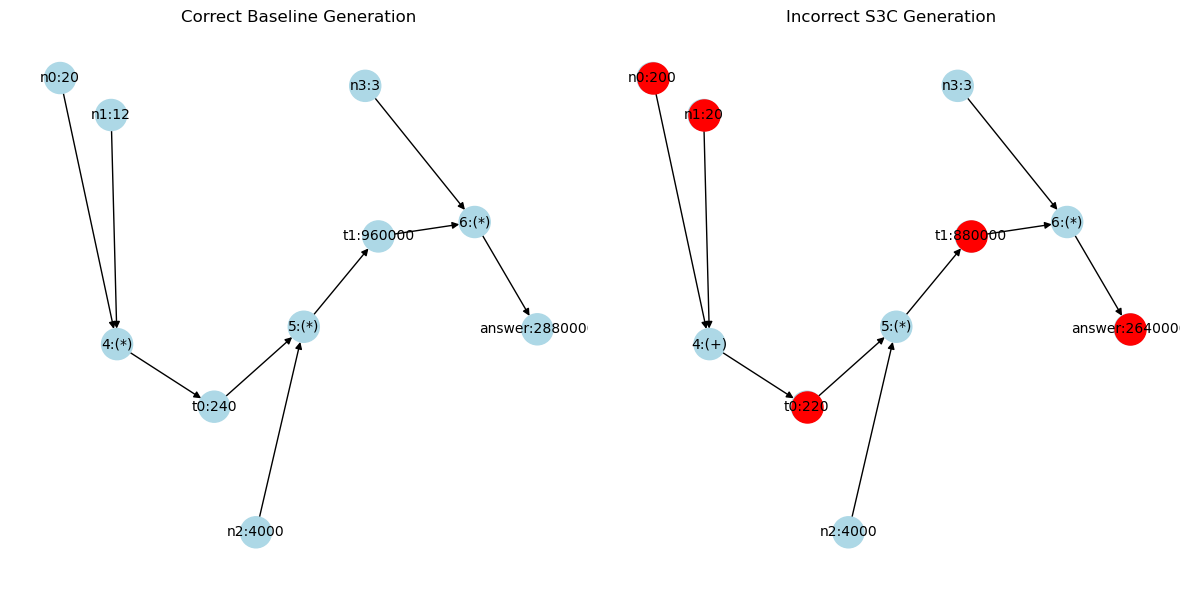

In [141]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re

# ... (previous code to parse the strings and create baseline_graph and s3c_graph)

# Function to set variable values and operators as attributes and labels in the graph nodes
def set_node_attributes(graph, var_values):
    for node, data in graph.nodes(data=True):
        if "value" in data:
            value = data["value"]
            data["label"] = f"{node}:{value}"
        elif "operator" in data:
            operator = data["operator"]
            data["label"] = operator
        else:
            data["label"] = node
        if node in var_values:
            if var_values[node] != data.get("value"):
                data["color"] = "red"
            else:
                data["color"] = "lightblue"
        else:
            data["color"] = "lightblue"

# Create a subgraph isomorphism matcher
matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

# Find all subgraph isomorphisms (common patterns)
subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

# Find the nodes with the same variable names in both graphs
shared_variable_nodes = set(baseline_graph.nodes()) & set(s3c_graph.nodes())

# Get the variable values for each graph
var_values_baseline = nx.get_node_attributes(baseline_graph, "value")
var_values_s3c = nx.get_node_attributes(s3c_graph, "value")

# Identify nodes with different values between the graphs
different_value_nodes = {node for node in shared_variable_nodes if var_values_baseline.get(node) != var_values_s3c.get(node)}

# Set node attributes and labels for visualization
set_node_attributes(baseline_graph, var_values_baseline)
set_node_attributes(s3c_graph, var_values_s3c)

# Create a new figure and axis for drawing the graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Draw the baseline graph
axes[0].set_title("Correct Baseline Generation")
pos_baseline = nx.spring_layout(baseline_graph, seed=42)
labels_baseline = nx.get_node_attributes(baseline_graph, "label")
colors_baseline = nx.get_node_attributes(baseline_graph, "color")
nx.draw(baseline_graph, pos=pos_baseline, labels=labels_baseline, node_color=list(colors_baseline.values()), node_size=500, font_size=10, ax=axes[0])

# Draw the s3c graph
axes[1].set_title("Incorrect S3C Generation")
pos_s3c = nx.spring_layout(s3c_graph, seed=42)
labels_s3c = nx.get_node_attributes(s3c_graph, "label")
colors_s3c = nx.get_node_attributes(s3c_graph, "color")
nx.draw(s3c_graph, pos=pos_s3c, labels=labels_s3c, node_color=list(colors_s3c.values()), node_size=500, font_size=10, ax=axes[1])

# Highlight nodes with different values between the graphs in red
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_value_nodes, node_color="red", node_size=500, ax=axes[1])

plt.tight_layout()
plt.show()


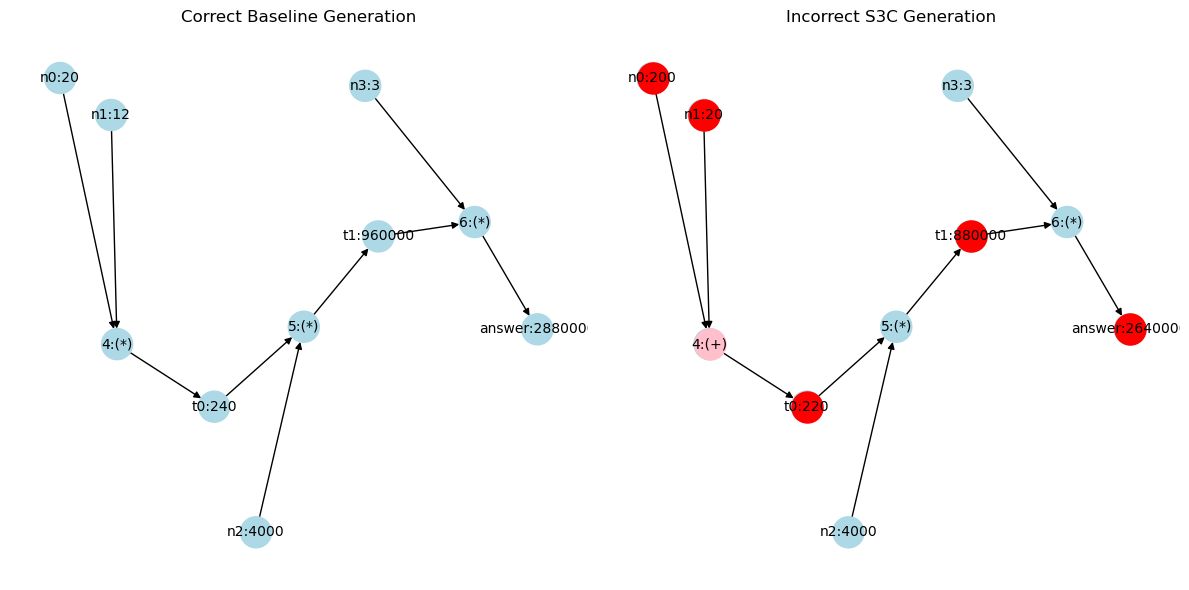

Unique nodes in Baseline Graph: {'4:(*)'}
Unique nodes in S3C Graph: {'4:(+)'}
Unique edges in Baseline Graph: {('4:(*)', 't0'), ('n0', '4:(*)'), ('n1', '4:(*)')}
Unique edges in S3C Graph: {('n0', '4:(+)'), ('n1', '4:(+)'), ('4:(+)', 't0')}


In [172]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re

# ... (previous code to parse the strings and create baseline_graph and s3c_graph)

# Function to set variable values and operators as attributes and labels in the graph nodes
def set_node_attributes(graph, var_values, operator_values):
    for node, data in graph.nodes(data=True):
        if "value" in data:
            value = data["value"]
            data["label"] = f"{node}:{value}"
            data["color"] = "red" if node in var_values and var_values[node] != value else "lightblue"
        elif "expression" in data:
            expression = data["expression"]
            data["label"] = expression
            data["color"] = "red" if node in operator_values and operator_values[node] != expression else "lightblue"
        else:
            data["label"] = node
            data["color"] = "lightblue"

# Create a subgraph isomorphism matcher
matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

# Find all subgraph isomorphisms (common patterns)
subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

# Find the nodes with the same variable names in both graphs
shared_variable_nodes = set(baseline_graph.nodes()) & set(s3c_graph.nodes())

# Get the variable values for each graph
var_values_baseline = nx.get_node_attributes(baseline_graph, "value")
var_values_s3c = nx.get_node_attributes(s3c_graph, "value")

# Identify nodes with different values between the graphs
different_value_nodes = {node for node in shared_variable_nodes if var_values_baseline.get(node) != var_values_s3c.get(node)}

# Get the expressions for each graph
expressions_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
expressions_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}

# Identify nodes with different expressions between the graphs
different_expression_nodes = {node for node in shared_variable_nodes if expressions_baseline.get(node) != expressions_s3c.get(node)}

# Set node attributes and labels for visualization
set_node_attributes(baseline_graph, var_values_baseline, expressions_baseline)
set_node_attributes(s3c_graph, var_values_s3c, expressions_s3c)

# Create a new figure and axis for drawing the graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Draw the baseline graph
axes[0].set_title("Correct Baseline Generation")
pos_baseline = nx.spring_layout(baseline_graph, seed=42)
labels_baseline = nx.get_node_attributes(baseline_graph, "label")
colors_baseline = nx.get_node_attributes(baseline_graph, "color")
nx.draw(baseline_graph, pos=pos_baseline, labels=labels_baseline, node_color=list(colors_baseline.values()), node_size=500, font_size=10, ax=axes[0])

# Draw the s3c graph
axes[1].set_title("Incorrect S3C Generation")
pos_s3c = nx.spring_layout(s3c_graph, seed=42)
labels_s3c = nx.get_node_attributes(s3c_graph, "label")
colors_s3c = nx.get_node_attributes(s3c_graph, "color")
nx.draw(s3c_graph, pos=pos_s3c, labels=labels_s3c, node_color=list(colors_s3c.values()), node_size=500, font_size=10, ax=axes[1])

# Highlight nodes with different values between the graphs in red
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_value_nodes, node_color="red", node_size=500, ax=axes[1])

# Highlight nodes with different expressions between the graphs in red
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_expression_nodes, node_color="red", node_size=500, ax=axes[1])

# Compare the operators between the graphs
operator_values_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
operator_values_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}
different_operator_nodes = {node for node in set(operator_values_baseline) & set(operator_values_s3c) if operator_values_baseline[node] != operator_values_s3c[node]}

# Find the nodes and edges that are unique to each graph
unique_nodes_baseline = set(baseline_graph.nodes()) - set(s3c_graph.nodes())
unique_nodes_s3c = set(s3c_graph.nodes()) - set(baseline_graph.nodes())

unique_edges_baseline = set(baseline_graph.edges()) - set(s3c_graph.edges())
unique_edges_s3c = set(s3c_graph.edges()) - set(baseline_graph.edges())

# # Find the nodes and edges that are unique to each graph
# unique_nodes_baseline = {node for node in baseline_graph.nodes() if baseline_graph.nodes[node].get("value") is not None}
# unique_nodes_s3c = {node for node in s3c_graph.nodes() if s3c_graph.nodes[node].get("value") is not None}

# unique_edges_baseline = set((u, v) for u, v, data in baseline_graph.edges(data=True) if data.get("operator") is None)
# unique_edges_s3c = set((u, v) for u, v, data in s3c_graph.edges(data=True) if data.get("operator") is None)


# Highlight nodes with different operators between the graphs in red
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=unique_nodes_s3c, node_color="pink", node_size=500, ax=axes[1])

plt.tight_layout()
plt.show()

# Print the unique nodes and edges in each graph
print("Unique nodes in Baseline Graph:", unique_nodes_baseline)
print("Unique nodes in S3C Graph:", unique_nodes_s3c)

print("Unique edges in Baseline Graph:", unique_edges_baseline)
print("Unique edges in S3C Graph:", unique_edges_s3c)


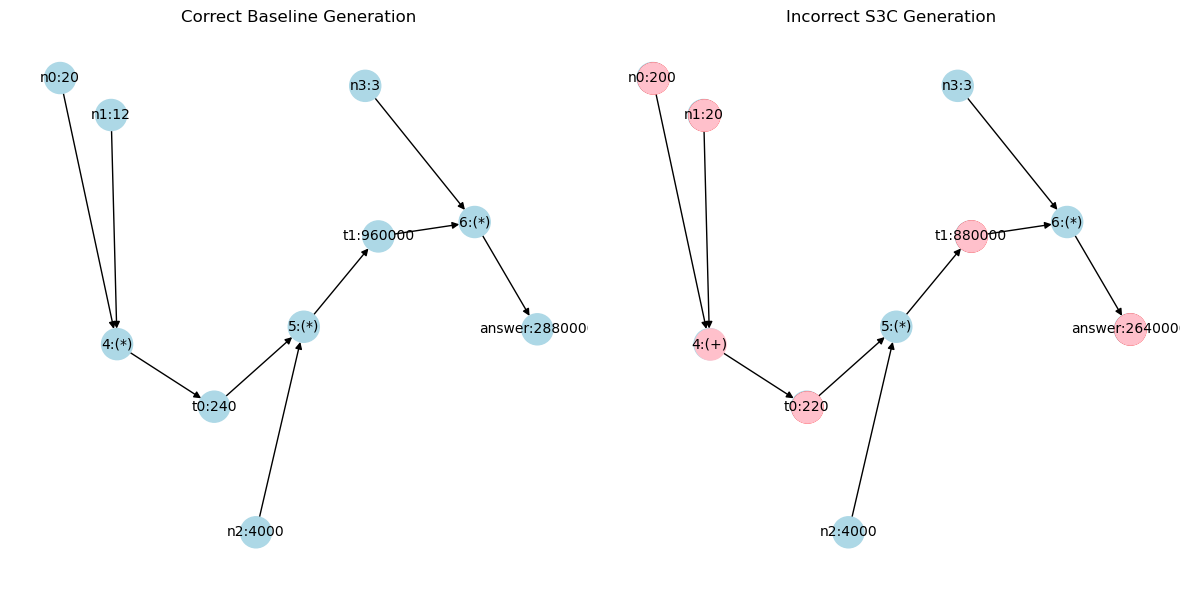

Unique nodes in Baseline Graph: {'n1', 'n0', 't0', 'answer', 't1', '4:(*)'}
Unique nodes in S3C Graph: {'n1', '4:(+)', 'n0', 't0', 'answer', 't1'}
Unique edges in Baseline Graph: {('4:(*)', 't0'), ('n0', '4:(*)'), ('n1', '4:(*)')}
Unique edges in S3C Graph: {('n0', '4:(+)'), ('n1', '4:(+)'), ('4:(+)', 't0')}


In [178]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re

# ... (previous code to parse the strings and create baseline_graph and s3c_graph)

# Function to set variable values and operators as attributes and labels in the graph nodes
def set_node_attributes(graph, var_values, operator_values):
    for node, data in graph.nodes(data=True):
        if "value" in data:
            value = data["value"]
            data["label"] = f"{node}:{value}"
            data["color"] = "red" if node in var_values and var_values[node] != value else "lightblue"
        elif "expression" in data:
            expression = data["expression"]
            data["label"] = expression
            data["color"] = "red" if node in operator_values and operator_values[node] != expression else "lightblue"
        else:
            data["label"] = node
            data["color"] = "lightblue"

# Create a subgraph isomorphism matcher
matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

# Find all subgraph isomorphisms (common patterns)
subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

# Find the nodes with the same variable names in both graphs
shared_variable_nodes = set(baseline_graph.nodes()) & set(s3c_graph.nodes())

# Get the variable values for each graph
var_values_baseline = nx.get_node_attributes(baseline_graph, "value")
var_values_s3c = nx.get_node_attributes(s3c_graph, "value")

# Identify nodes with different values between the graphs
different_value_nodes = {node for node in shared_variable_nodes if var_values_baseline.get(node) != var_values_s3c.get(node)}

# Get the expressions for each graph
expressions_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
expressions_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}

# Identify nodes with different expressions between the graphs
different_expression_nodes = {node for node in shared_variable_nodes if expressions_baseline.get(node) != expressions_s3c.get(node)}

# Set node attributes and labels for visualization
set_node_attributes(baseline_graph, var_values_baseline, expressions_baseline)
set_node_attributes(s3c_graph, var_values_s3c, expressions_s3c)

# Create a new figure and axis for drawing the graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Draw the baseline graph
axes[0].set_title("Correct Baseline Generation")
pos_baseline = nx.spring_layout(baseline_graph, seed=42)
labels_baseline = nx.get_node_attributes(baseline_graph, "label")
colors_baseline = nx.get_node_attributes(baseline_graph, "color")
nx.draw(baseline_graph, pos=pos_baseline, labels=labels_baseline, node_color=list(colors_baseline.values()), node_size=500, font_size=10, ax=axes[0])

# Draw the s3c graph
axes[1].set_title("Incorrect S3C Generation")
pos_s3c = nx.spring_layout(s3c_graph, seed=42)
labels_s3c = nx.get_node_attributes(s3c_graph, "label")
colors_s3c = nx.get_node_attributes(s3c_graph, "color")
nx.draw(s3c_graph, pos=pos_s3c, labels=labels_s3c, node_color=list(colors_s3c.values()), node_size=500, font_size=10, ax=axes[1])

# Highlight nodes with different values between the graphs in red
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_value_nodes, node_color="red", node_size=500, ax=axes[1])

# Highlight nodes with different expressions between the graphs in red
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_expression_nodes, node_color="red", node_size=500, ax=axes[1])

# Highlight nodes with different operators between the graphs in red
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_operator_nodes, node_color="red", node_size=500, ax=axes[1])

# Compare the operators between the graphs
operator_values_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
operator_values_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}
different_operator_nodes = {node for node in set(operator_values_baseline) & set(operator_values_s3c) if operator_values_baseline[node] != operator_values_s3c[node]}

# # Find the nodes and edges that are unique to each graph
# unique_nodes_baseline = set(baseline_graph.nodes()) - set(s3c_graph.nodes())
# unique_nodes_s3c = set(s3c_graph.nodes()) - set(baseline_graph.nodes())

# unique_edges_baseline = set(baseline_graph.edges()) - set(s3c_graph.edges())
# unique_edges_s3c = set(s3c_graph.edges()) - set(baseline_graph.edges())

# Find the nodes and edges that are unique to each graph
unique_nodes_baseline = set(node for node in baseline_graph.nodes() if node not in s3c_graph.nodes() or (node in shared_variable_nodes and var_values_baseline.get(node) != var_values_s3c.get(node)))
unique_nodes_s3c = set(node for node in s3c_graph.nodes() if node not in baseline_graph.nodes() or (node in shared_variable_nodes and var_values_s3c.get(node) != var_values_baseline.get(node)))

unique_edges_baseline = set((u, v) for u, v, data in baseline_graph.edges(data=True) if (u, v) not in s3c_graph.edges() and data.get("operator") is None)
unique_edges_s3c = set((u, v) for u, v, data in s3c_graph.edges(data=True) if (u, v) not in baseline_graph.edges() and data.get("operator") is None)


# # Find the nodes and edges that are unique to each graph
# unique_nodes_baseline = {node for node in baseline_graph.nodes() if baseline_graph.nodes[node].get("value") is not None}
# unique_nodes_s3c = {node for node in s3c_graph.nodes() if s3c_graph.nodes[node].get("value") is not None}

# unique_edges_baseline = set((u, v) for u, v, data in baseline_graph.edges(data=True) if data.get("operator") is None)
# unique_edges_s3c = set((u, v) for u, v, data in s3c_graph.edges(data=True) if data.get("operator") is None)


# Highlight nodes with different operators between the graphs in red
nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=unique_nodes_s3c, node_color="pink", node_size=500, ax=axes[1])

plt.tight_layout()
plt.show()

# Print the unique nodes and edges in each graph
print("Unique nodes in Baseline Graph:", unique_nodes_baseline)
print("Unique nodes in S3C Graph:", unique_nodes_s3c)

print("Unique edges in Baseline Graph:", unique_edges_baseline)
print("Unique edges in S3C Graph:", unique_edges_s3c)
